# Setup

In [ ]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data Pipeline


In [ ]:
drive.mount("/content/drive")
file_path = "/content/drive/My Drive/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# class MinMaxScaler:
#     def fit(self, data):
#         self.min = np.min(data, axis=0)
#         self.max = np.max(data, axis=0)
#         self.range = self.max - self.min

#     def transform(self, data):
#         return (data - self.min) / self.range

#     def inverse_transform(self, data):
#         return data * self.range + self.min

In [ ]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    close_data = data["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled, columns=["Close"])

    def split_dataframe(df, chunk_size):
        return [df[i:i + chunk_size] for i in range(0, df.shape[0] - chunk_size + 1)]

    sections = split_dataframe(data_scaled, seq_length)

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 1)
            y = data[i + x_size:i + x_size + 1].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
        return torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_val), torch.Tensor(y_test)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)  # Initial cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Training

In [ ]:
# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
seq_length = 60
learning_rate = 0.01
num_epochs = 200
batch_size = 64

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/200], Loss: 0.0001
Epoch [20/200], Loss: 0.0001
Epoch [30/200], Loss: 0.0002
Epoch [40/200], Loss: 0.0002
Epoch [50/200], Loss: 0.0004
Epoch [60/200], Loss: 0.0004
Epoch [70/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0003
Epoch [90/200], Loss: 0.0002
Epoch [100/200], Loss: 0.0002
Epoch [110/200], Loss: 0.0001
Epoch [120/200], Loss: 0.0001
Epoch [130/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0002
Epoch [150/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [170/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [190/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0002


# Visualization

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
mse = torch.mean((predictions - y_train) ** 2)
print(f"Training Loss Scaling Unreversed: {mse.item()}")

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions.numpy()))
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_train.numpy()))
mse_reversed = torch.mean((predictions_reversed - y_train_reversed) ** 2)
print(f"Training Loss Scaling Reversed: {mse_reversed.item()}")

Predicted value for the first sample: 0.0059
Training Loss Scaling Unreversed: 0.00023184705059975386
Training Loss Scaling Reversed: 1212124.25


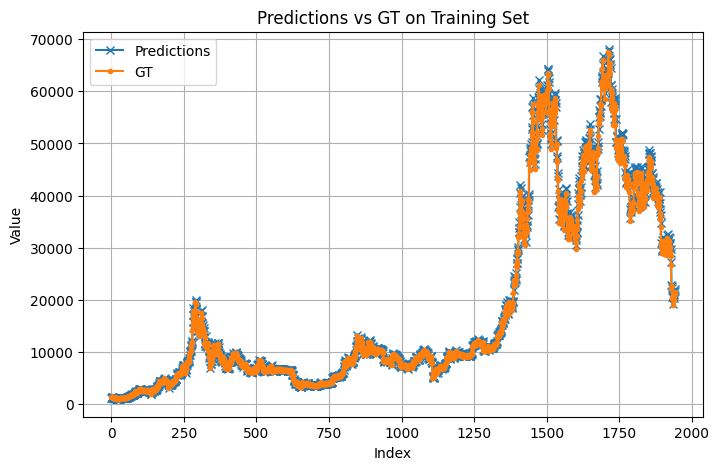

In [ ]:
import matplotlib.pyplot as plt
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

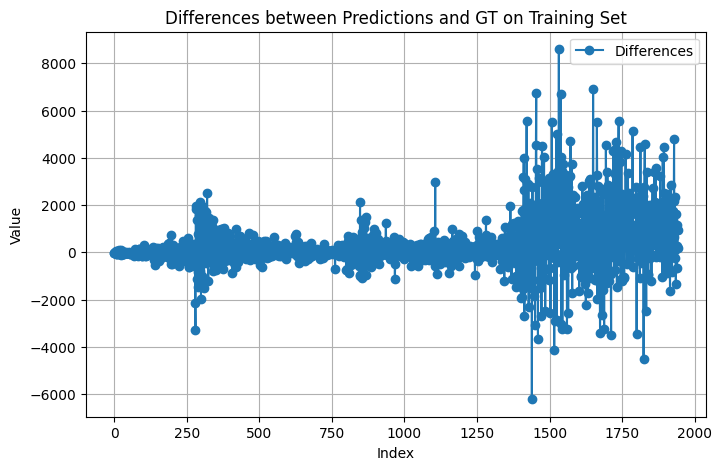

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Differences', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
mse = torch.mean((predictions - y_val) ** 2)
print(f"Training Loss Scaling Unreversed: {mse.item()}")

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions.numpy()))
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_val.numpy()))
mse_reversed = torch.mean((predictions_reversed - y_val_reversed) ** 2)
print(f"Training Loss Scaling Reversed: {mse_reversed.item()}")

Predicted value for the first sample: 0.2873
Training Loss Scaling Unreversed: 0.0001249559863936156
Training Loss Scaling Reversed: 653284.9375


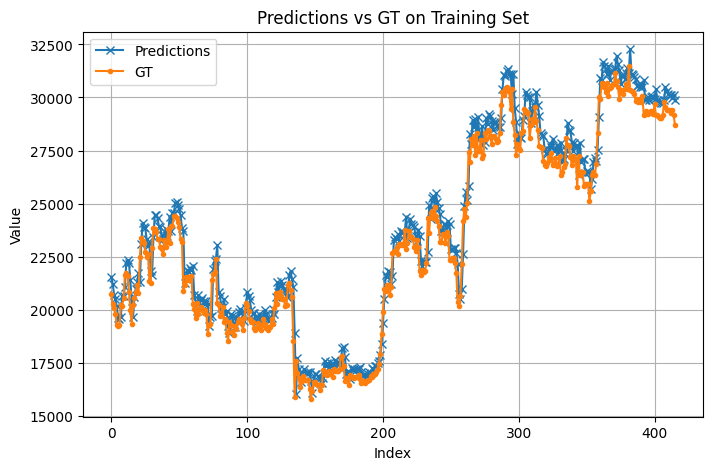

In [88]:
import matplotlib.pyplot as plt
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

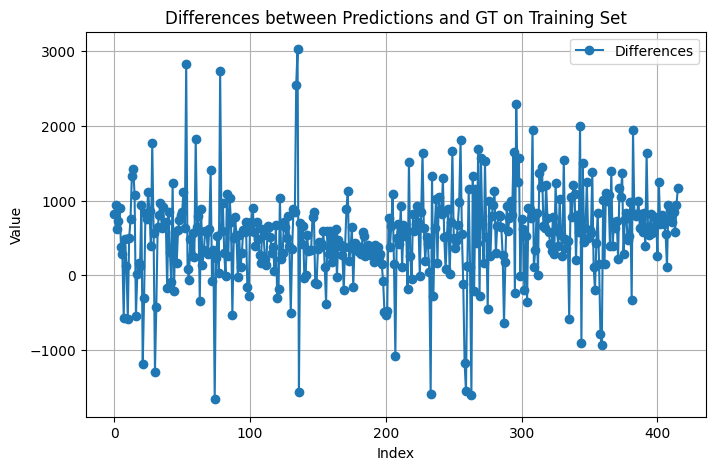

In [89]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Differences', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()